# Deep Learning
## Assignment 3

Previously in 2_fullyconnected.ipynb, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.


In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt


First reload the data we generated in 1_notmnist.ipynb.


In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:

    * data as a flat matrix,
    * labels as float 1-hot encodings.



In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

## Problem 1

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor t using nn.l2_loss(t). The right amount of regularization should improve your validation / test accuracy.


In [9]:
## Logistic regression with regularization
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul2 = tf.placeholder(tf.float32)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
    beta_regul2* tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  #valid_prediction = tf.nn.softmax(
  #  tf.matmul(tf_valid_dataset, weights) + biases)
  #test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
  def calc_prediction(X):
        outputLayer = tf.nn.softmax(tf.matmul(X, weights) + biases)
        return outputLayer
  test_prediction = calc_prediction(tf_test_dataset)
  valid_prediction = calc_prediction(tf_valid_dataset)
    
    # now run the training
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul2: 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 21.212198
Minibatch accuracy: 14.1%
Validation accuracy: 12.9%
Minibatch loss at step 500: 2.683192
Minibatch accuracy: 78.1%
Validation accuracy: 76.1%
Minibatch loss at step 1000: 1.384890
Minibatch accuracy: 85.9%
Validation accuracy: 78.8%
Minibatch loss at step 1500: 1.427944
Minibatch accuracy: 71.9%
Validation accuracy: 80.2%
Minibatch loss at step 2000: 0.963595
Minibatch accuracy: 80.5%
Validation accuracy: 81.0%
Minibatch loss at step 2500: 0.836461
Minibatch accuracy: 84.4%
Validation accuracy: 80.7%
Minibatch loss at step 3000: 0.804502
Minibatch accuracy: 77.3%
Validation accuracy: 81.8%
Test accuracy: 89.0%


## Discussion
accuracy on test has definitely improved from 85% to 89 %. However it introduces another hyper parameter "beta_regul2" that needs to be tuned on the validation set.
Lets change the value of the param "beta_regul2" and see how the validation accuray changes.

In [12]:
beta_list = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1]
print(beta_list)

[0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]


In [20]:
# now run the training for each beta in the beta_list
valid_accuracy =[]
best_accuracy =0
best_beta = beta_list[0]
for beta in beta_list:
    print(" training for beta = %f " %beta)
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print("initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # used a better randomization across epochs
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch
            batch_data = train_dataset[offset:offset+batch_size, :]
            batch_labels = train_labels[offset:offset+batch_size, :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta_regul2: beta}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
        # out of for loop- finished num_steps for current beta
        curr_valid_accu = accuracy(valid_prediction.eval(), valid_labels)
        valid_accuracy.append(curr_valid_accu)
        if (curr_valid_accu > best_accuracy):
                best_accuracy = curr_valid_accu
                best_beta = beta
        
        
    

 training for beta = 0.000100 
initialized
 training for beta = 0.000300 
initialized
 training for beta = 0.001000 
initialized
 training for beta = 0.003000 
initialized
 training for beta = 0.010000 
initialized
 training for beta = 0.030000 
initialized
 training for beta = 0.100000 
initialized
 training for beta = 0.300000 
initialized


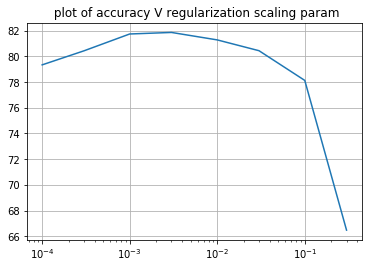

The best beta is 0.003000 with best validation accracy of 81.850000


In [21]:
# now plot the graph
import matplotlib.pyplot as plt
plt.semilogx(beta_list, valid_accuracy)
plt.title(" plot of accuracy V regularization scaling param")
plt.grid(True)
plt.show()
print("The best beta is %f with best validation accracy of %f" %(best_beta, best_accuracy))

### Optimum beta is 0.003; hence we need to retrain with this value to obtain the true test accuracy
### Note: one cannot tune hyperparater to maximize the test accuracy! usign test dataet for hyperparamter tuning is cheating

In [26]:
with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print("initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # used a better randomization across epochs
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch
            batch_data = train_dataset[offset:offset+batch_size, :]
            batch_labels = train_labels[offset:offset+batch_size, :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta_regul2: best_beta}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
            if (step%500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch train accuracy %f " % accuracy(predictions, batch_labels))
        print(" training completed")
        print(" final validation accuracy: ", accuracy(valid_prediction.eval(), valid_labels))
        print(" final test accuracy: ", accuracy(test_prediction.eval(), test_labels))
                

initialized
Minibatch loss at step 0: 24.661728
Minibatch train accuracy 12.500000 
Minibatch loss at step 500: 2.631405
Minibatch train accuracy 78.125000 
Minibatch loss at step 1000: 0.804276
Minibatch train accuracy 85.156250 
Minibatch loss at step 1500: 0.933653
Minibatch train accuracy 73.437500 
Minibatch loss at step 2000: 0.779794
Minibatch train accuracy 80.468750 
Minibatch loss at step 2500: 0.689051
Minibatch train accuracy 85.156250 
Minibatch loss at step 3000: 0.753786
Minibatch train accuracy 78.906250 
 training completed
 final validation accuracy:  81.79
 final test accuracy:  88.74


## Regularized 3 layer NN

In [27]:
batch_size = 128
num_nodes_hidden_layer1 = 1024
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  beta_regul2 = tf.placeholder(tf.float32)
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  #1st layer nodes = 784 =image_size*image_size
  #2nd layer nodes(hidden layer) = 1024(=num_nodes_hidden_layer1)
  #3rd layer nodes(output node, FC) = 10(= num_labels)
  # hiddenout = relu(X*W1 + b1); the shape of weights and input X should allow matrix multiplication
  # bias(b1), should be of shape [1, 1024]
  # X:shape = [batch_size,784]
  #define weights1 [784, 1024]
  weights1 = tf.Variable(tf.truncated_normal(shape=[image_size*image_size, num_nodes_hidden_layer1]))
  bias1 = tf.Variable(tf.zeros(shape =[1, num_nodes_hidden_layer1]))
  
  #hidden layer output = X*W1 +b1
  hidden_out = tf.add(tf.matmul(tf_train_dataset, weights1), bias1)
  hidden_out = tf.nn.relu(hidden_out)
  # shape of hidden_out = [batch_size, 1024]
  #now define the output layer as fully connected layer(FC)
  weights2 = tf.Variable(tf.truncated_normal(shape=[num_nodes_hidden_layer1, num_labels]))

  bias2 = tf.Variable(tf.zeros(shape=[1, num_labels]))
  prediction_logit = tf.add(tf.matmul(hidden_out, weights2), bias2)
  #prediction_out = tf.nn.softmax(prediction_logit)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= prediction_logit,labels= tf_train_labels)) + \
    beta_regul2*(tf.nn.l2_loss(weights1)+ tf.nn.l2_loss(weights2))
  optimizer = tf.train.GradientDescentOptimizer(0.2).minimize(loss)
  #predictions for train, valid and test data
  nntrain_prediction = tf.nn.softmax(prediction_logit)
  #define  afunction that calculates prediction using the layer1 and layer2  learned parameters
  def calc_prediction(X):
        layer1 = tf.nn.relu(tf.matmul(X, weights1)+ bias1)
        outputLayer = tf.nn.softmax(tf.matmul(layer1, weights2) + bias2)
        return outputLayer
  valid_prediction = calc_prediction(tf_valid_dataset)
  test_prediction = calc_prediction(tf_test_dataset)

In [29]:
# now run the training
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul2:3e-3}
    _, l, predictions = session.run(
      [optimizer, loss, nntrain_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Train Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 1202.828857
Train Minibatch accuracy: 15.6%
Validation accuracy: 33.0%
Minibatch loss at step 500: 520.317505
Train Minibatch accuracy: 84.4%
Validation accuracy: 82.0%
Minibatch loss at step 1000: 281.583069
Train Minibatch accuracy: 83.6%
Validation accuracy: 83.1%
Minibatch loss at step 1500: 154.296570
Train Minibatch accuracy: 80.5%
Validation accuracy: 84.5%
Minibatch loss at step 2000: 84.558937
Train Minibatch accuracy: 84.4%
Validation accuracy: 85.5%
Minibatch loss at step 2500: 46.317482
Train Minibatch accuracy: 86.7%
Validation accuracy: 86.2%
Minibatch loss at step 3000: 25.680408
Train Minibatch accuracy: 86.7%
Validation accuracy: 87.1%
Test accuracy: 93.1%


Now we will plot the same graph; beta Vs accuracy

In [30]:
# now run the training for each beta in the beta_list
valid_accuracy =[]
best_accuracy =0
best_beta = beta_list[0]
for beta in beta_list:
    print(" training for beta = %f " %beta)
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print("initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # used a better randomization across epochs
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch
            batch_data = train_dataset[offset:offset+batch_size, :]
            batch_labels = train_labels[offset:offset+batch_size, :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta_regul2: beta}
            _, l, predictions = session.run([optimizer, loss, nntrain_prediction], feed_dict = feed_dict)
        # out of for loop- finished num_steps for current beta
        curr_valid_accu = accuracy(valid_prediction.eval(), valid_labels)
        valid_accuracy.append(curr_valid_accu)
        if (curr_valid_accu > best_accuracy):
                best_accuracy = curr_valid_accu
                best_beta = beta

 training for beta = 0.000100 
initialized
 training for beta = 0.000300 
initialized
 training for beta = 0.001000 
initialized
 training for beta = 0.003000 
initialized
 training for beta = 0.010000 
initialized
 training for beta = 0.030000 
initialized
 training for beta = 0.100000 
initialized
 training for beta = 0.300000 
initialized


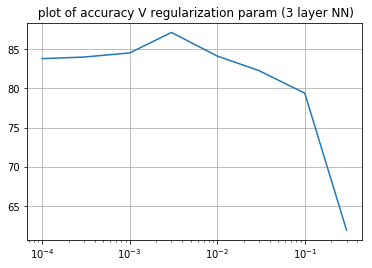

The best beta is 0.003000 with best validation accracy of 87.140000


In [31]:
# now plot the graph
import matplotlib.pyplot as plt
plt.semilogx(beta_list, valid_accuracy)
plt.title(" plot of accuracy V regularization param (3 layer NN)")
plt.grid(True)
plt.show()
print("The best beta is %f with best validation accracy of %f" %(best_beta, best_accuracy))

## Problem 2

Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

we will attempt this problem by running the training for a percentage of batch size(25%) instead of complete batch size(128). To make this more visible clear, we will introduce a new loop for no_of_epochs and run through the SGD batch.


In [7]:
num_nodes_hidden_layer1 = 1024
batch_size = 128
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  beta_regul2 = tf.placeholder(tf.float32)
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  #1st layer nodes = 784 =image_size*image_size
  #2nd layer nodes(hidden layer) = 1024(=num_nodes_hidden_layer1)
  #3rd layer nodes(output node, FC) = 10(= num_labels)
  # hiddenout = relu(X*W1 + b1); the shape of weights and input X should allow matrix multiplication
  # bias(b1), should be of shape [1, 1024]
  # X:shape = [batch_size,784]
  #define weights1 [784, 1024]
  weights1 = tf.Variable(tf.truncated_normal(shape=[image_size*image_size, num_nodes_hidden_layer1]))
  bias1 = tf.Variable(tf.zeros(shape =[1, num_nodes_hidden_layer1]))
  
  #hidden layer output = X*W1 +b1
  hidden_out = tf.add(tf.matmul(tf_train_dataset, weights1), bias1)
  hidden_out = tf.nn.relu(hidden_out)
  # shape of hidden_out = [batch_size, 1024]
  #now define the output layer as fully connected layer(FC)
  weights2 = tf.Variable(tf.truncated_normal(shape=[num_nodes_hidden_layer1, num_labels]))

  bias2 = tf.Variable(tf.zeros(shape=[1, num_labels]))
  prediction_logit = tf.add(tf.matmul(hidden_out, weights2), bias2)
  #prediction_out = tf.nn.softmax(prediction_logit)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= prediction_logit,labels= tf_train_labels)) + \
    beta_regul2*(tf.nn.l2_loss(weights1)+ tf.nn.l2_loss(weights2))
  optimizer = tf.train.GradientDescentOptimizer(0.2).minimize(loss)
  #predictions for train, valid and test data
  nntrain_prediction = tf.nn.softmax(prediction_logit)
  #define  afunction that calculates prediction using the layer1 and layer2  learned parameters
  def calc_prediction(X):
        layer1 = tf.nn.relu(tf.matmul(X, weights1)+ bias1)
        outputLayer = tf.nn.softmax(tf.matmul(layer1, weights2) + bias2)
        return outputLayer
  valid_prediction = calc_prediction(tf_valid_dataset)
  test_prediction = calc_prediction(tf_test_dataset)

In [14]:
# now training
# define epochs = no of times to run through the data
epochs = 3

with tf.Session(graph= graph) as session:
    tf.global_variables_initializer().run()
    print(" global variables initialization complete ")
    # num_batches = no of steps required to complete one pass of train_dataset
    num_batches = int(len(train_dataset)/batch_size)
    for i in range(epochs):
        print("********epoch no %d********* " %i)
        for n in range(num_batches):
            # Pick an offset within the training data, which has been randomized.
            offset = (n * batch_size) # % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:offset+batch_size, :]
            batch_labels = train_labels[offset:offset+batch_size, :]
            feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels, beta_regul2:3e-3 }
            # making beta_regu=0 as we want to introduce overfitting
            _,l, prediction = session.run([optimizer, loss,nntrain_prediction], feed_dict = feed_dict)
            if(((i+1)*n) % 500 == 0):
                print("At step = %d, minibatch loss =%f "%((n+1)*(i+1), l))
                print("minibatch train accuracy = ", accuracy(prediction, batch_labels))
        print("After epoch %d, validation accuracy = %f" %(i, accuracy(valid_prediction.eval(), valid_labels)) )
        print("Test accuracy = %f" % accuracy(test_prediction.eval(), test_labels) )
    print(" Final Test accuracy = %f" % accuracy(test_prediction.eval(), test_labels) )
            
    

 global variables initialization complete 
********epoch no 0********* 
At step = 1, minibatch loss =1298.718262 
minibatch train accuracy =  6.25
At step = 501, minibatch loss =522.078674 
minibatch train accuracy =  81.25
At step = 1001, minibatch loss =281.130310 
minibatch train accuracy =  87.5
At step = 1501, minibatch loss =154.259048 
minibatch train accuracy =  80.46875
After epoch 0, validation accuracy = 83.350000
Test accuracy = 90.100000
********epoch no 1********* 
At step = 2, minibatch loss =142.761124 
minibatch train accuracy =  84.375
At step = 502, minibatch loss =105.884590 
minibatch train accuracy =  82.8125
At step = 1002, minibatch loss =78.136848 
minibatch train accuracy =  86.71875
At step = 1502, minibatch loss =58.089394 
minibatch train accuracy =  84.375
At step = 2002, minibatch loss =42.866852 
minibatch train accuracy =  93.75
At step = 2502, minibatch loss =31.987947 
minibatch train accuracy =  88.28125
At step = 3002, minibatch loss =23.874964 
min

For problem 2 we will modify the above training and feed the overlapping sequence of training data(similar). 
Since the model will see almost same data for training, training accuracy will be ~100% but low generalization

In [18]:
# now training
# define epochs = no of times to run through the data
epochs = 3

with tf.Session(graph= graph) as session:
    tf.global_variables_initializer().run()
    print(" global variables initialization complete ")
    # num_batches = no of steps required to complete one pass of train_dataset
    num_batches = int(len(train_dataset)/batch_size)
    for i in range(epochs):
        print("********epoch no %d********* " %i)
        for n in range(num_batches):
            # Pick an offset within the training data, which has been randomized.
            #offset = (n * batch_size) # 
            offset = int(i * batch_size)# we will train on the same dataset multiple times
            batch_data = train_dataset[offset:offset+batch_size, :]
            batch_labels = train_labels[offset:offset+batch_size, :]
            feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels, beta_regul2:0 }
            # make beta_regu=0 if we want to introduce more overfitting
            _,l, prediction = session.run([optimizer, loss,nntrain_prediction], feed_dict = feed_dict)
            if(((i+1)*n) % 500 == 0):
                print("At step = %d, minibatch loss =%f "%((n+1)*(i+1), l))
                print("minibatch train accuracy = ", accuracy(prediction, batch_labels))
        print("After epoch %d, validation accuracy = %f" %(i, accuracy(valid_prediction.eval(), valid_labels)) )
        print("Test accuracy = %f" % accuracy(test_prediction.eval(), test_labels) )
    print(" Final Test accuracy = %f" % accuracy(test_prediction.eval(), test_labels) )

 global variables initialization complete 
********epoch no 0********* 
At step = 1, minibatch loss =332.773010 
minibatch train accuracy =  10.15625
At step = 501, minibatch loss =0.000000 
minibatch train accuracy =  100.0
At step = 1001, minibatch loss =0.000000 
minibatch train accuracy =  100.0
At step = 1501, minibatch loss =0.000000 
minibatch train accuracy =  100.0
After epoch 0, validation accuracy = 60.950000
Test accuracy = 68.200000
********epoch no 1********* 
At step = 2, minibatch loss =135.155670 
minibatch train accuracy =  59.375
At step = 502, minibatch loss =0.000000 
minibatch train accuracy =  100.0
At step = 1002, minibatch loss =0.000000 
minibatch train accuracy =  100.0
At step = 1502, minibatch loss =0.000000 
minibatch train accuracy =  100.0
At step = 2002, minibatch loss =0.000000 
minibatch train accuracy =  100.0
At step = 2502, minibatch loss =0.000000 
minibatch train accuracy =  100.0
At step = 3002, minibatch loss =0.000000 
minibatch train accuracy

Try different offset such as
- 1) offset = int((n% epochs) * batch_size)
- 2) offset = int(n * batch_size/32)

Even regularization will not improve the  train accuracy

## Problem 3

Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides nn.dropout() for that, but you have to make sure it's only inserted during training.

In [19]:
num_nodes_hidden_layer1 = 1024
batch_size = 128
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  beta_regul2 = tf.placeholder(tf.float32)
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  #1st layer nodes = 784 =image_size*image_size
  #2nd layer nodes(hidden layer) = 1024(=num_nodes_hidden_layer1)
  #3rd layer nodes(output node, FC) = 10(= num_labels)
  # hiddenout = relu(X*W1 + b1); the shape of weights and input X should allow matrix multiplication
  # bias(b1), should be of shape [1, 1024]
  # X:shape = [batch_size,784]
  #define weights1 [784, 1024]
  weights1 = tf.Variable(tf.truncated_normal(shape=[image_size*image_size, num_nodes_hidden_layer1]))
  bias1 = tf.Variable(tf.zeros(shape =[1, num_nodes_hidden_layer1]))
  
  #hidden layer output = X*W1 +b1
  hidden_lay1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1)+ bias1)
  hidden_out = tf.nn.dropout(hidden_lay1, 0.5)# dropout added to training
  # shape of hidden_out = [batch_size, 1024]
  #now define the output layer as fully connected layer(FC)
  weights2 = tf.Variable(tf.truncated_normal(shape=[num_nodes_hidden_layer1, num_labels]))
  bias2 = tf.Variable(tf.zeros(shape=[1, num_labels]))
  prediction_logit = tf.add(tf.matmul(hidden_out, weights2), bias2)
  #prediction_out = tf.nn.softmax(prediction_logit)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= prediction_logit,labels= tf_train_labels)) + \
  beta_regul2*(tf.nn.l2_loss(weights1)+ tf.nn.l2_loss(weights2))
  # we will make beta_regu =0 to make it non-regularized
  optimizer = tf.train.GradientDescentOptimizer(0.2).minimize(loss)
  #predictions for train, valid and test data
  nntrain_prediction = tf.nn.softmax(prediction_logit)
  #define  afunction that calculates prediction using the layer1 and layer2  learned parameters
    # note this function does not use dropout ( dropout is only for training)
  def calc_prediction(X):
        layer1 = tf.nn.relu(tf.matmul(X, weights1)+ bias1)
        outputLayer = tf.nn.softmax(tf.matmul(layer1, weights2) + bias2)
        return outputLayer
  valid_prediction = calc_prediction(tf_valid_dataset)
  test_prediction = calc_prediction(tf_test_dataset)

In [21]:
# now training
# define epochs = no of times to run through the data
epochs = 3

with tf.Session(graph= graph) as session:
    tf.global_variables_initializer().run()
    print(" global variables initialization complete ")
    # num_batches = no of steps required to complete one pass of train_dataset
    num_batches = int(len(train_dataset)/batch_size)
    for i in range(epochs):
        print("********epoch no %d********* " %i)
        for n in range(num_batches):
            # Pick an offset within the training data, which has been randomized.
            #offset = (n * batch_size) # 
            offset = int(i * batch_size)# we will train on the same dataset multiple times
            batch_data = train_dataset[offset:offset+batch_size, :]
            batch_labels = train_labels[offset:offset+batch_size, :]
            feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels, beta_regul2:0 }
            # make beta_regu=0 if we want to introduce more overfitting
            _,l, prediction = session.run([optimizer, loss,nntrain_prediction], feed_dict = feed_dict)
            if(((i+1)*n) % 500 == 0):
                print("At step = %d, minibatch loss =%f "%((n+1)*(i+1), l))
                print("minibatch train accuracy = ", accuracy(prediction, batch_labels))
        print("After epoch %d, validation accuracy = %f" %(i, accuracy(valid_prediction.eval(), valid_labels)) )
        print("Test accuracy = %f" % accuracy(test_prediction.eval(), test_labels) )
    print(" Final Test accuracy = %f" % accuracy(test_prediction.eval(), test_labels) )

 global variables initialization complete 
********epoch no 0********* 
At step = 1, minibatch loss =505.557404 
minibatch train accuracy =  11.71875
At step = 501, minibatch loss =0.000000 
minibatch train accuracy =  100.0
At step = 1001, minibatch loss =0.085312 
minibatch train accuracy =  99.21875
At step = 1501, minibatch loss =0.000000 
minibatch train accuracy =  100.0
After epoch 0, validation accuracy = 68.450000
Test accuracy = 75.250000
********epoch no 1********* 
At step = 2, minibatch loss =145.655945 
minibatch train accuracy =  66.40625
At step = 502, minibatch loss =0.000000 
minibatch train accuracy =  100.0
At step = 1002, minibatch loss =0.000000 
minibatch train accuracy =  100.0
At step = 1502, minibatch loss =0.000000 
minibatch train accuracy =  100.0
At step = 2002, minibatch loss =0.000000 
minibatch train accuracy =  100.0
At step = 2502, minibatch loss =0.000000 
minibatch train accuracy =  100.0
At step = 3002, minibatch loss =0.000000 
minibatch train acc

## Discussion: problem3
- The test accuracy incresed slightly from 80% to 84%
- This is extreme overfitting hence ther is not visible difference.
- Note only 3*128 no of dataset are fed for training(This is extreme overfitting)
- The usefulness of dropout would be relevant in case of very deep layer network( i guess)
- Tenchnically, dropout does same job as L2 regularization, i.e. preventing overfitting


## Problem 4

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is 97.1%.

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

global_step = tf.Variable(0)  # count the number of steps taken.
learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

- we will attempt to use 4 layer NN(2 hidden),L2 regularization, dropout, and learning rate decay


In [30]:
num_nodes_hidden_layer1 = 1024
num_nodes_hidden_layer2 = 128 # keeping multiple of 2^N
batch_size = 128
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  beta_regul2 = tf.placeholder(tf.float32)
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  keep_prob = tf.placeholder(tf.float32)
  #1st layer nodes = 784 =image_size*image_size
  #2nd layer nodes(hidden layer1) = 1024(=num_nodes_hidden_layer1)
  # 3rd layer node(hidden layer2) = 128
  #4th layer nodes(output node, FC) = 10(= num_labels)
 
  weights1 = tf.Variable(tf.random_normal(shape=[image_size*image_size, num_nodes_hidden_layer1],  stddev = 0.01))
  bias1 = tf.Variable(tf.zeros(shape =[1, num_nodes_hidden_layer1]))
  
  weights2 = tf.Variable(tf.random_normal(shape=[num_nodes_hidden_layer1, num_nodes_hidden_layer2], stddev =0.01))
  bias2 = tf.Variable(tf.zeros(shape=[1, num_nodes_hidden_layer2]))
  
  weights3 = tf.Variable(tf.random_normal(shape=[num_nodes_hidden_layer2, num_labels], stddev =0.01))
  bias3 = tf.Variable(tf.zeros(shape=[1, num_labels]))

  #hidden layer output = X*W1 +b1
  hidden_lay1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights1)+ bias1)
  lay1_out = tf.nn.dropout(hidden_lay1, keep_prob)# dropout added to training
  
  hidden_lay2 = tf.nn.relu(tf.matmul(lay1_out, weights2)+ bias2)
  lay2_out = tf.nn.dropout(hidden_lay2, keep_prob)
  
  prediction_logit = tf.add(tf.matmul(lay2_out, weights3), bias3)
  #prediction_out = tf.nn.softmax(prediction_logit)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= prediction_logit,labels= tf_train_labels)) + \
  beta_regul2*(tf.nn.l2_loss(weights1)+ tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
  # we can make beta_regu =0 to make it non-regularized
  
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(0.2, global_step,1000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step = global_step)
  #optimizer = tf.train.GradientDescentOptimizer(0.2).minimize(loss)
  #predictions for train, valid and test data
  nntrain_prediction = tf.nn.softmax(prediction_logit)
  #define  afunction that calculates prediction using the layer1 and layer2  learned parameters
    # note this function does not use dropout ( dropout is only for training)
  def calc_prediction(X):
        layer1 = tf.nn.relu(tf.matmul(X, weights1)+ bias1)
        layer2 = tf.nn.relu(tf.matmul(layer1, weights2)+ bias2)
        outputLayer = tf.nn.softmax(tf.matmul(layer2, weights3) + bias3)
        return outputLayer
  valid_prediction = calc_prediction(tf_valid_dataset)
  test_prediction = calc_prediction(tf_test_dataset)

In [31]:
# now training
# define epochs = no of times to run through the data
epochs = 5

with tf.Session(graph= graph) as session:
    tf.global_variables_initializer().run()
    print(" global variables initialization complete ")
    # num_batches = no of steps required to complete one pass of train_dataset
    num_batches = int(len(train_dataset)/batch_size)
    for i in range(epochs):
        print("********epoch no %d********* " %i)
        for n in range(num_batches):
            # Pick an offset within the training data, which has been randomized.
            offset = (n * batch_size) # 
            #offset = int(i * batch_size)# we will train on the same dataset multiple times
            batch_data = train_dataset[offset:offset+batch_size, :]
            batch_labels = train_labels[offset:offset+batch_size, :]
            feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels, beta_regul2:1e-3, keep_prob: 1 }
            # make beta_regu=0 if we want to introduce more overfitting
            _,l, prediction = session.run([optimizer, loss,nntrain_prediction], feed_dict = feed_dict)
            if(((i+1)*n) % 500 == 0):
                print("At step = %d, minibatch loss =%f "%((n+1)*(i+1), l))
                print("minibatch train accuracy = ", accuracy(prediction, batch_labels))
        print("After epoch %d, validation accuracy = %f" %(i, accuracy(valid_prediction.eval(), valid_labels)) )
        print("Test accuracy = %f" % accuracy(test_prediction.eval(), test_labels) )
    print(" Final Test accuracy = %f" % accuracy(test_prediction.eval(), test_labels) )

 global variables initialization complete 
********epoch no 0********* 
At step = 1, minibatch loss =2.349010 
minibatch train accuracy =  14.84375
At step = 501, minibatch loss =0.542205 
minibatch train accuracy =  85.9375
At step = 1001, minibatch loss =0.376830 
minibatch train accuracy =  92.1875
At step = 1501, minibatch loss =0.608721 
minibatch train accuracy =  83.59375
After epoch 0, validation accuracy = 86.890000
Test accuracy = 93.120000
********epoch no 1********* 
At step = 2, minibatch loss =0.492205 
minibatch train accuracy =  90.625
At step = 502, minibatch loss =0.466378 
minibatch train accuracy =  88.28125
At step = 1002, minibatch loss =0.409575 
minibatch train accuracy =  90.625
At step = 1502, minibatch loss =0.500743 
minibatch train accuracy =  86.71875
At step = 2002, minibatch loss =0.329183 
minibatch train accuracy =  93.75
At step = 2502, minibatch loss =0.515460 
minibatch train accuracy =  86.71875
At step = 3002, minibatch loss =0.531918 
minibatch t

Thats my best score(94.8%)
For some reason, disbaling dropout gives better performance in my case;
I can probably try to increase the accuracy to 96% by including additional layer, but will not try it.
Hopefully, using CNN in next lesson will improve accuracy drastically